<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>


* <a href='#model'>Model definition and hyperparameter optimization</a>
    * <a href='#model:cat_oc'>One Class classification models</a>
        * <a href='#model_oc:ocsvm'>One Class SVM</a>
        * <a href='#model_oc:AU'>One Class AutoEncoder</a>
        * <a href='#model_oc:...'>...</a>
        
    * <a href='#model:cat_binary'>Binary (supervised) classification models</a>
        * <a href='#model_binary:svm'>SVM</a>
        * <a href='#model_binary:AU'>Autoencoder</a>
        * <a href='#model_binary:...'>...</a>

        
* <a href='#results'>Results</a>
* <a href='#conclusions'>Conclusions</a>


    


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [162]:
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm
from scipy import stats
import warnings
from ipywidgets import IntProgress
from IPython import display
#############
from sklearn.svm import OneClassSVM
from pyod.models import ocsvm

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, auc, plot_roc_curve
from sklearn.metrics import confusion_matrix
import time
import os
from IPython.display import Image

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

**Environment configuration**

In [94]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None, range_rows=None)

<a href='#index'>...</a>
<a id='data'></a>
# Processed data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [312]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_151
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [313]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
random_state = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, random_state):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
              
    CORE_collection[RS] = (X[0]['CORE'],X[1]['CORE'])
    X_collection[RS] = (X[0].drop(columns=['CORE']), X[1].drop(columns=['CORE']))
    Y_collection[RS] = (Y[0], Y[1])

    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

**Function definition**

In [97]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [98]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [99]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [100]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y['ED0DISWHY']==1]
    anomaly_index = index[Y['ED0DISWHY']==-1]
    X_normal = X.iloc[normal_index]
    X_anomaly = X.iloc[anomaly_index]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [101]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

**0 value percetange per column.**

Printing the percentage of samples with value 0 per all columns. Excluiding those features which have 0 as a suitable value.

In [102]:
zero_relevance_columns = ['CT0000ADW', 'CT00000AP', 'CT000APTT', 'CT00000BT', 'CT000CHCM', 'CT00000DD', 'CT0000GGT', 'CT0000GLU', 'CT0000GOT', 'CT0000GPT', 'CT0000HCM', 'CT000HCTO', 'CT0000HEM', 'CT0000HGB', 'CT0000INR', 'CT000000K', 'CT0000LDH', 'CT000LEUC', 'CT0000LIN', 'CT000LINP', 'CT00MONOP', 'CT00000NA', 'CT0000NEU', 'CT000NEUP', 'CT0000PCR', 'CT000PLAQ', 'CT00000TP', 'CT000000U', 'CT0000VCM', 'CT0000VPM', 'CTHSDXXRATE','CTHSDXXSAT']
zero_relevance(X_data, zero_relevance_columns)

Percentage of 0's per column:
* CT0000ADW 	0 (0.00%)
* CT00000AP 	0 (0.00%)
* CT000APTT 	0 (0.00%)
* CT00000BT 	0 (0.00%)
* CT000CHCM 	0 (0.00%)
* CT00000DD 	0 (0.00%)
* CT0000GGT 	0 (0.00%)
* CT0000GLU 	0 (0.00%)
* CT0000GOT 	0 (0.00%)
* CT0000GPT 	0 (0.00%)
* CT0000HCM 	0 (0.00%)
* CT000HCTO 	0 (0.00%)
* CT0000HEM 	0 (0.00%)
* CT0000HGB 	0 (0.00%)
* CT0000INR 	0 (0.00%)
* CT000000K 	0 (0.00%)
* CT0000LDH 	0 (0.00%)
* CT000LEUC 	0 (0.00%)
* CT0000LIN 	0 (0.00%)
* CT000LINP 	0 (0.00%)
* CT00MONOP 	0 (0.00%)
* CT00000NA 	0 (0.00%)
* CT0000NEU 	0 (0.00%)
* CT000NEUP 	0 (0.00%)
* CT0000PCR 	0 (0.00%)
* CT000PLAQ 	0 (0.00%)
* CT00000TP 	0 (0.00%)
* CT000000U 	0 (0.00%)
* CT0000VCM 	0 (0.00%)
* CT0000VPM 	0 (0.00%)
* CTHSDXXRATE 	0 (0.00%)
* CTHSDXXSAT 	0 (0.00%)


**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

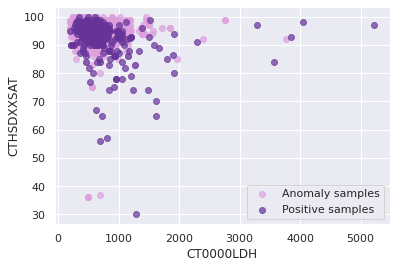

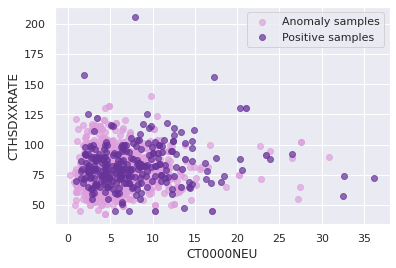

In [103]:
plot_pair_individual(X_data, Y_data, 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data, 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

Text(0.5, 1.08, "Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)")

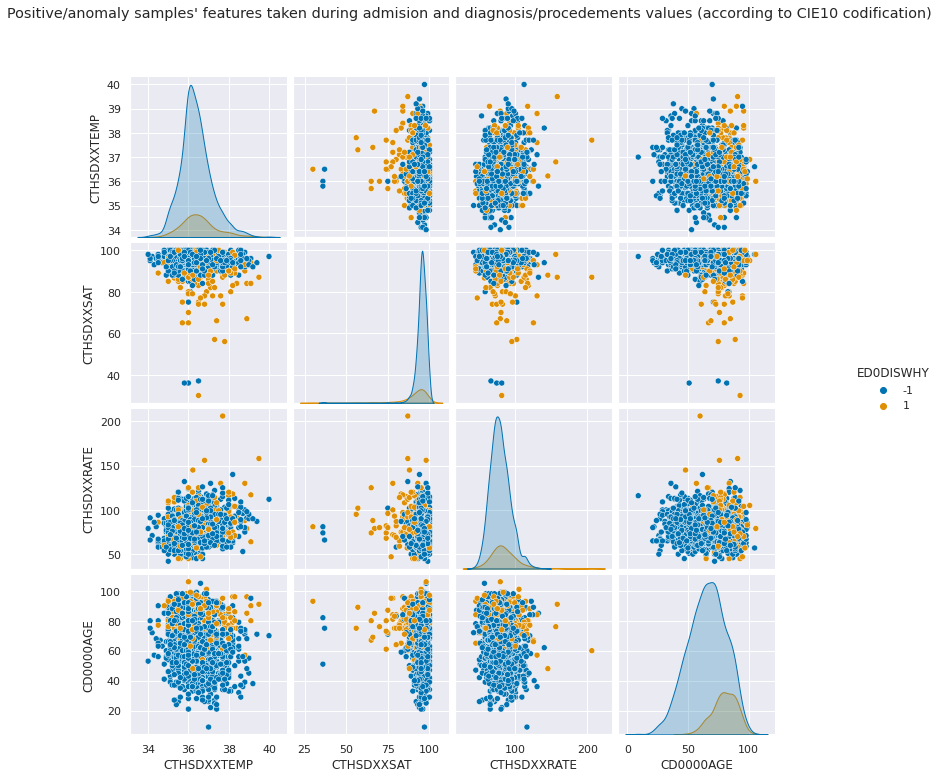

In [104]:
sns.set()

pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.


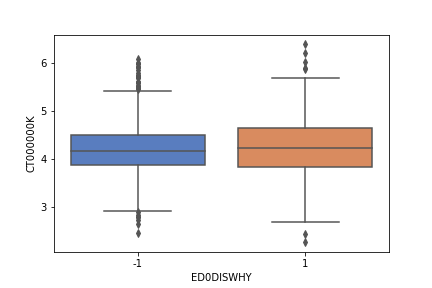

In [105]:
Image(filename='boxplots/bp_CT000000K.png')

<a href='#index'>...</a>
<a id='model'></a>
# Model definition and hyperparameter optimization

**Function definition**

In [106]:
def normalize(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [107]:
def oc_split(Y, train, test, normal):
    indexed_train = zip(np.arange(0,train.shape[0],1), train)
    # Index to remove from train set
    del_index = []

    for train_index, df_index in tqdm(indexed_train, total=train.shape[0], desc = 'Transfering anomaly samples from train to test'): 
        sample = Y.iloc[df_index]
        if (sample['ED0DISWHY']!=normal):
            # Append anomaly samples from train to test
            test = np.append(test, df_index)
            # Update train (anomaly) indexes
            del_index.append(train_index)
    # Remove anomaly samples from train
    train = np.delete(train, del_index, 0)
    return train, test


In [540]:
def nested_cv(X, Y, outer_folds, inner_folds, model, parameters, score, one_class=0, normal_target=1):

    outer_loop=1
    max_score = -1
    score_outer = []
    inner_results = []
    
    # Define outer-loop
    skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
    for train_outer, test_outer in skfold_outer.split(X, Y):
        display.clear_output(wait=True)
        
        print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))
        
        # Outer-loop data retrieve
        X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
        Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]
        
        # Define inner loop
        skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)
        
        # Transfering anomaly samples from train to test subsets.
        if (one_class):
            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((oc_split(Y, train_inner, test_inner, normal_target)))
        else:
            skfold_inner_cv = skfold_inner
            
        # GRIDSEARCH
        # Obtain best model
        scorer = make_scorer(score, pos_label=normal_target)#, average='weighted')
#         scorer = make_scorer(precision_score, pos_label=normal_target)
#         scorer = make_scorer(recall_score, pos_label=normal_target)
#         scorer = make_scorer(f1_score, pos_label=normal_target)
        gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
        gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
        inner_results.append(gsearch.cv_results_)
        
        # Best estimator
        estimator = gsearch.best_estimator_
        pred_y = estimator.predict(X_test_outer)
#         print('Predited Y: \n {} \n'.format(pred_y))
#         print('Ground truth Y: \n {} \n'.format(Y.iloc[test_outer]))
#         score = f1_score(Y.iloc[test_outer], pred_y)
#         score = precision_score(Y.iloc[test_outer], pred_y, np.unique)
        score_val = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)#,average='micro')
        score_outer.append(score_val)
        if (score_val>=max(score_outer)): best_estimator = estimator
            
        outer_loop+=1
#         time.sleep(10)
    display.clear_output(wait=True)
    
    print("Metrics: f1-score")
    print("Summary:")
    for i in range(outer_folds):
        best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
        print("Outer fold nº{}.".format(i+1))
        print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
        print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
        print("Score (outer): {:.4}\n".format(score_outer[i]))
    return best_estimator
        

<a id='model:cat_oc'></a>
## One Class classification models

TODO: EXPLANATION

<a id='model_oc:ocsvm'></a>
## One Class SVM

TODO: EXPLANATION
- MODEL
    - Parameters
        - Nu is the parameter that controls the training errors (and the number of SVs). This parameter is always within the range (0,1].
        - Gamma parameter determines the influence of radius on the kernel. The range of this parameter depends on your data and application.
- OUTLIERNESS

***
**UNIVERSE 1**

Normal class: ***deceased***

In [442]:
low_gamma = 2e-8
top_gamma = 2e-7

low_nu = 1e-6
top_nu = 1e-5
np.linspace(low_gamma, top_gamma, 5+1)[1:]

array([5.60e-08, 9.20e-08, 1.28e-07, 1.64e-07, 2.00e-07])

In [552]:
ocsvm = OneClassSVM()
normal = 1

low_gamma = 1e-9
top_gamma = 1e-7

low_nu = 1
top_nu = 1e-5

ocsvm_params= {
        'gamma' : np.linspace(low_gamma, top_gamma, 8+1)[1:],
        'nu' : np.linspace(low_nu, top_nu, 5+1)[1:]
    }

# Obtain model with best hyperparameters: nested-cv
estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)

# Fit train data
index_normal = Y_collection[42][0].loc[Y_collection[42][0]['ED0DISWHY']==1].index
estimator_ocsvm.fit(X_collection[42][0].iloc[index_normal])

# Predict unproccessed outlier-score
decicision_function = estimator_ocsvm.decision_function(X_collection[42][1])

# Process outlier-score or outlierness
# Outlier-score:
# Lower the score, lower the likelihood of being outlier.
# Higher the score, higher the likelihood of being outlier.
MIN = min(decicision_function)
outlier_score = decicision_function - MIN



Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'gamma': 1.3375e-08, 'nu': 0.400006}
Score (best of cv): 0.259±0.0077
Score (outer): 0.2165

Outer fold nº2.
Parameters (best of cv): {'gamma': 1.3375e-08, 'nu': 0.20000799999999996}
Score (best of cv): 0.253±0.0046
Score (outer): 0.2308

Outer fold nº3.
Parameters (best of cv): {'gamma': 1.3375e-08, 'nu': 0.20000799999999996}
Score (best of cv): 0.249±0.0022
Score (outer): 0.229

Outer fold nº4.
Parameters (best of cv): {'gamma': 1.3375e-08, 'nu': 0.20000799999999996}
Score (best of cv): 0.237±0.003
Score (outer): 0.2214

Outer fold nº5.
Parameters (best of cv): {'gamma': 1.3375e-08, 'nu': 0.20000799999999996}
Score (best of cv): 0.241±0.0044
Score (outer): 0.2741



0.1893491124260355


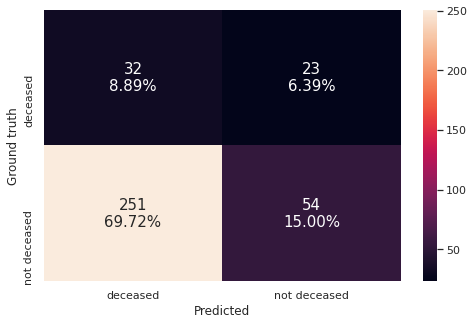

In [550]:
estimator_ocsvm = OneClassSVM(gamma= 0.00001,  nu=0.005)


# Obtain model with best hyperparameters: nested-cv
#estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=recall_score, one_class=1, normal_target = 1)

# Parameter sharing
# best_estimator_params = estimator_ocsvm.get_params()
# models_ocsvm = OneClassSVM()
# models_ocsvm.set_params(**best_estimator_params)

# Fit test data
estimator_ocsvm.fit(X_collection[42][0])

# Predict unproccessed outlier-score
decicision_function = estimator_ocsvm.decision_function(X_collection[42][1])

# Process outlier-score or outlierness
# Outlier-score:
# Lower the score, lower the likelihood of being outlier.
# Higher the score, higher the likelihood of being outlier.
MIN = min(decicision_function)
outlier_score = decicision_function - MIN

pred = estimator_ocsvm.predict(X_collection[42][1])

print(f1_score(Y_collection[42][1]['ED0DISWHY'],pred,pos_label = 1))

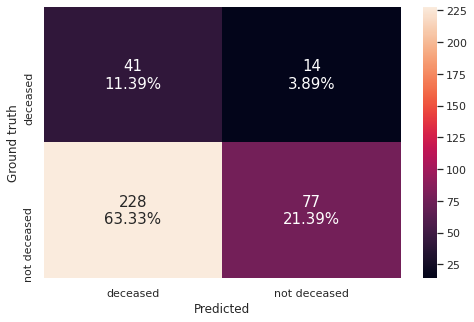

In [553]:
pred = estimator_ocsvm.predict(X_collection[42][1])

array = confusion_matrix(y_true=Y_collection[42][1], y_pred=pred, labels=[1,-1])
normal = 'deceased'
anomaly = 'not deceased'

df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

total = df_cm[normal].sum()+df_cm[anomaly].sum()

df_cm_p = df_cm.applymap(str)
df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

plt.figure(figsize=(8,5))

sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
plt.ylabel("Ground truth")
plt.xlabel("Predicted") 

plt.show()

**Outlierness representation**

<AxesSubplot:title={'center':'Outlierness per class distribution'}, xlabel='Outlier-score', ylabel='Class'>

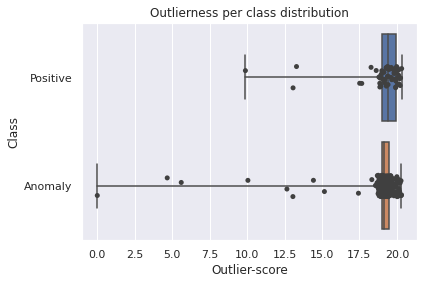

In [554]:
# Visualization of the outlierness distribution
index = Y_collection[42][1].index
anomaly_index = index[Y_collection[42][1]['ED0DISWHY']==-1]
positive_index = index[Y_collection[42][1]['ED0DISWHY']==1]
d = {'Outlier-score':outlier_score[positive_index], 'Class':len(outlier_score[positive_index])*['Positive']}
df_positive = pd.DataFrame(data=d)
d = {'Outlier-score':outlier_score[anomaly_index], 'Class':len(outlier_score[anomaly_index])*['Anomaly']}
df_anomaly = pd.DataFrame(data=d)

df_scores = pd.concat([df_positive, df_anomaly])

plt.title('Outlierness per class distribution')

# plt.xlim([500, 650])
sns.boxplot(y='Class', x='Outlier-score', data=df_scores, whis=np.inf)
sns.stripplot(y='Class', x='Outlier-score', data=df_scores, color=".25")


**ROC**

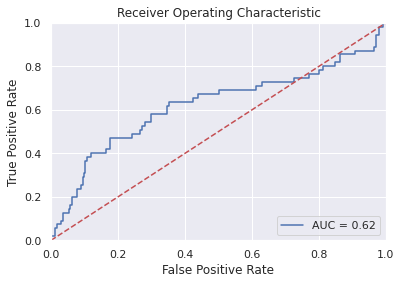

In [555]:
norm_outlier_score = normalize(outlier_score)
fpr, tpr, thresholds = roc_curve(Y_collection[42][1], norm_outlier_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Results**

Normal class: ***not deceased***

In [556]:
ocsvm = OneClassSVM()
normal = -1

low_gamma = 1e-9
top_gamma = 1e-7

low_nu = 1
top_nu = 1e-5

ocsvm_params = {
        'gamma': np.linspace(low_gamma, top_gamma, 5+1)[1:],
        'nu': np.linspace(low_nu, top_nu, 5+1)[1:]
    }

# Obtain model with best hyperparameters: nested-cv
estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, score=f1_score, parameters=ocsvm_params, one_class=1, normal_target = -1)

# Fit train data
index_normal = Y_collection[42][0].loc[Y_collection[42][0]['ED0DISWHY']==normal].index
estimator_ocsvm.fit(X_collection[42][0].iloc[index_normal])


# Predict unproccessed outlier-score
decicision_function = estimator_ocsvm.decision_function(X_collection[42][1])

# Process outlier-score or outlierness
# Outlier-score:
# Lower the score, lower the likelihood of being outlier.
# Higher the score, higher the likelihood of being outlier.

MIN = min(decicision_function)
outlier_score = decicision_function - MIN

Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'gamma': 2.0799999999999998e-08, 'nu': 1e-05}
Score (best of cv): 0.915±0.0053
Score (outer): 0.07634

Outer fold nº2.
Parameters (best of cv): {'gamma': 6.04e-08, 'nu': 1e-05}
Score (best of cv): 0.921±0.0016
Score (outer): 0.9146

Outer fold nº3.
Parameters (best of cv): {'gamma': 1e-07, 'nu': 1e-05}
Score (best of cv): 0.924±0.0029
Score (outer): 0.9153

Outer fold nº4.
Parameters (best of cv): {'gamma': 1e-07, 'nu': 1e-05}
Score (best of cv): 0.911±0.0018
Score (outer): 0.615

Outer fold nº5.
Parameters (best of cv): {'gamma': 1e-07, 'nu': 1e-05}
Score (best of cv): 0.921±0.0043
Score (outer): 0.8659



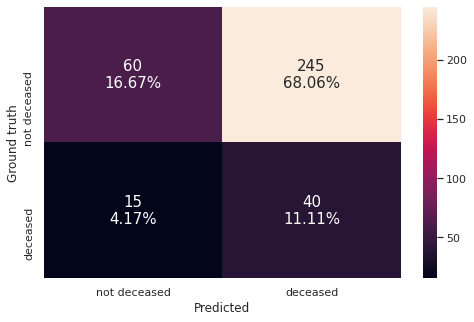

In [557]:
pred = estimator_ocsvm.predict(X_collection[42][1])

array = confusion_matrix(y_true=Y_collection[42][1], y_pred=pred, labels=[-1,1])
normal = 'not deceased'
anomaly = 'deceased'

df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

total = df_cm[normal].sum()+df_cm[anomaly].sum()

df_cm_p = df_cm.applymap(str)
df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

plt.figure(figsize=(8,5))

sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
plt.ylabel("Ground truth")
plt.xlabel("Predicted") 

plt.show()

**Outlierness representation**

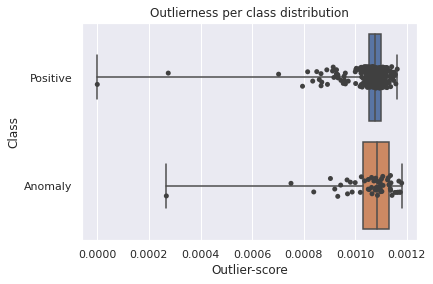

In [558]:
# Visualization of the outlierness distribution

index = Y_collection[42][1].index
anomaly_index = index[Y_collection[42][1]['ED0DISWHY']==1]
positive_index = index[Y_collection[42][1]['ED0DISWHY']==-1]
d = {'Outlier-score':outlier_score[positive_index], 'Class':len(outlier_score[positive_index])*['Positive']}
df_positive = pd.DataFrame(data=d)
d = {'Outlier-score':outlier_score[anomaly_index], 'Class':len(outlier_score[anomaly_index])*['Anomaly']}
df_anomaly = pd.DataFrame(data=d)

df_scores = pd.concat([df_positive, df_anomaly])

plt.title('Outlierness per class distribution')
sns.boxplot(y='Class', x='Outlier-score', data=df_scores, whis=np.inf)
sns.stripplot(y='Class', x='Outlier-score', data=df_scores, color=".25")

plt.show()

**ROC**

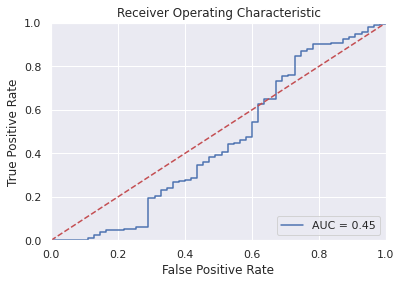

In [559]:
norm_outlier_score = normalize(outlier_score)
fpr, tpr, thresholds = roc_curve(Y_collection[42][1], norm_outlier_score, pos_label=-1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id='model:cat_binary'></a>
## Binary (supervised) classification models
